<a href="https://colab.research.google.com/github/IsaacFigNewton/Text-to-Timeline/blob/main/Sample_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Packages

In [1]:
# Broken libraries I've tried: AllenNLP, Coreferee, neuralcoref, spacy-experimental, stanford-corenlp (only api available)
!pip install fastcoref
!pip install intervaltree

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
 

In [2]:
!git clone https://github.com/IsaacFigNewton/Text-to-Timeline.git

Cloning into 'Text-to-Timeline'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 28 (delta 5), reused 13 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 66.21 KiB | 533.00 KiB/s, done.
Resolving deltas: 100% (5/5), done.


# Import Libraries

In [3]:
import sys
import os
import json
import spacy
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
from fastcoref import FCoref, spacy_component

In [5]:
# Add the timeline reconstruction modules directory to the Python path
module_path = os.path.abspath('./Text-to-Timeline/modules')
if module_path not in sys.path:
    sys.path.append(module_path)

from pipeline import *
from utils import plot_graph_from_edge_list

In [6]:
default_nlp_model = spacy.load("en_core_web_sm")

fastcoref_model = FCoref()

coref_resolution_model = spacy.load("en_core_web_sm", exclude=["parser", "lemmatizer", "ner", "textcat"])
coref_resolution_model.add_pipe("fastcoref")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/362M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/362M [00:00<?, ?B/s]

# Config

In [7]:
tests = [
    "The frog jumped over the goose. Mr. Holmes is gay. Then the frog fell into the abyss. The goose followed the frog into the abyss and after that ate a different frog.",
    # "Although he was very busy with his work, Peter had had enough of it. He and his wife decided they needed a holiday. They travelled to Spain because they loved the country very much.",
    # "John met Paul after he finished work. He suggested they grab a drink.",
    # "The book was on the table when Sarah handed it to Mary. She smiled and thanked her.",
    # "Tom told Jerry that he had failed the exam.",
    # "The city council refused the demonstrators a permit because they feared violence.",
    # "Anna told Lucy that her idea was brilliant.",
    # "The scientist interviewed the assistant while she was setting up the experiment.",
    # "After the dog bit the man, he ran away.",
    # "The mechanic fixed the car while it was raining. He was soaked by the end.",
    # "David thanked Michael after his birthday party.",
    # "Karen lent her book to Julie because she needed it for class."
]

In [8]:
default_nlp_model = spacy.load("en_core_web_sm")

fastcoref_model = FCoref()

coref_resolution_model = spacy.load("en_core_web_sm", exclude=["parser", "lemmatizer", "ner", "textcat"])
coref_resolution_model.add_pipe("fastcoref")

# Helper functions

In [9]:
def run_tests(texts:str):
  ambiguated_texts = [[t, None] for t in texts]
  ambiguated_test = None

  for i in range(len(texts)):
    _, ambiguated_test = ambiguate_text(texts[i])
    ambiguated_texts[i][1] = ambiguated_test

  for test in ambiguated_texts:
    print(f"original:\n{test[0]}")
    print(f"disambiguated:\n{test[1]}")
    # print()

# Tests

In [10]:
test_infos = []
for test in tests:
  test_info = get_text_info_json(text=test,
                                 nlp_model=default_nlp_model,
                                 fastcoref_model=fastcoref_model,
                                 coref_resolution_model=coref_resolution_model)
  test_infos.append(test_info)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

/content/Text-to-Timeline/modules/utils.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


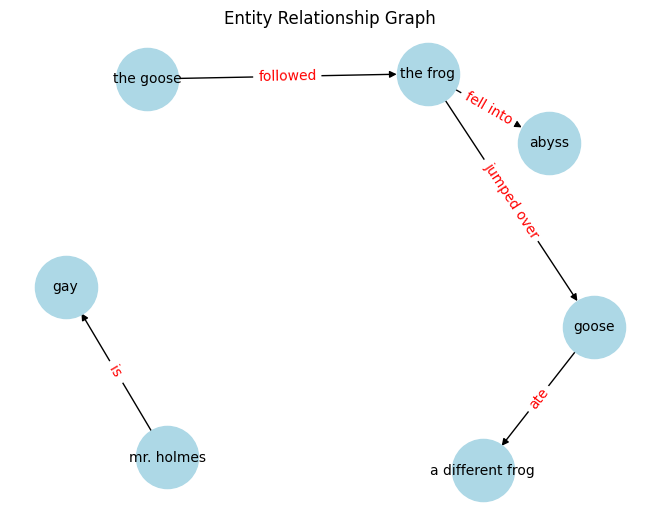

In [11]:
plot_graph_from_edge_list(test_infos[0]["edges"])